<a href="https://colab.research.google.com/github/Artin-Tavasoli/Neural-Network/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# 🧠 Convolutional vs. Fully Connected Neural Networks

###  **Artin Tavasoli** 👋🏻
📘 **Student ID:** `810102543`

</div>


# Overview
In this assignment, we will compare fully connected neural networks with convolutional neural networks to evaluate whether convolutional architectures offer superior performance—and understand the reasons behind any observed differences.



<span style="font-size:30px; font-weight:bold; color:pink;">📚 Import Needed Libraries</span>


In [1]:
import torch
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import math

## Device

As demonstrated in the PyTorch tutorial, PyTorch enable you to run your code on GPU to accelerate computations.

In [2]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device

# Dataset

## Transforms & Dataset & Dataloader

transforms.Compose: applies a sequence of transformations within in it in a sequential order to the input image.

transforms.ToTensor:  converts the images from a PIL Image format to a PyTorch tensor

transforms.Normalize: normalizes each pixel's values, mean and standard deviation of the CIFAR-10 dataset for each color channel (Red, Green, Blue) are given as a tuple.

Why Normalize?

 - Gradient descent algorithms might oscillate or take longer to find the optimal solution. Normalizing the data helps ensure that all features are on a similar scale, which can lead to faster convergence during training.

- Neural networks are sensitive to the scale of input features. If the features have widely varying ranges, the weights in the network will need to adjust to accommodate these differences.

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

To shuffle or not?

- Shuffling the training data in each epoch helps the model see different combinations of data in each batch which helps in avoiding learning patterns based on the order of samples.

- Evaluation is Order-Independent,  When calculating metrics like loss and accuracy on the validation and test sets, the order in which the samples are processed does not matter.

In [5]:
batch_size = 512

initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:10<00:00, 15.8MB/s]


What are Dataloaders?
- They are iterables that provide batches of data

- according to code below:

    each batch contains 512 images and each image has 32 * 32 pixels and 3 RGB values
    
    total dimension for each batch = 32,32,3

In [6]:
for batch_idx, (images, labels) in enumerate(trainloader):
    print('images shape is: ',images.shape)
    print('labels shape is: ',labels.shape)
    for image in images:
      print('image shape is: ', image.shape)
      print('an image in tensor format: \n',image)
      break
    break

images shape is:  torch.Size([512, 3, 32, 32])
labels shape is:  torch.Size([512])
image shape is:  torch.Size([3, 32, 32])
an image in tensor format: 
 tensor([[[-0.3525, -0.3684, -0.3367,  ..., -0.2573, -0.2573, -0.2890],
         [-0.3049, -0.3208, -0.2890,  ..., -0.2097, -0.2414, -0.2414],
         [-0.3049, -0.3049, -0.2890,  ..., -0.1938, -0.2573, -0.2414],
         ...,
         [-0.8765, -0.8924, -0.8765,  ..., -0.7653, -0.7018, -0.7018],
         [-0.8606, -0.8447, -0.7971,  ..., -0.7653, -0.7018, -0.7177],
         [-0.4161, -0.4478, -0.1461,  ..., -0.7495, -0.7177, -0.7336]],

        [[ 0.3081,  0.2919,  0.3242,  ...,  0.4372,  0.4372,  0.4210],
         [ 0.3565,  0.3404,  0.3726,  ...,  0.4533,  0.4856,  0.4695],
         [ 0.3726,  0.3565,  0.3726,  ...,  0.5017,  0.5017,  0.4695],
         ...,
         [-0.1599, -0.1922, -0.1761,  ..., -0.0470, -0.0631, -0.0147],
         [-0.1438, -0.1599, -0.0954,  ..., -0.0308, -0.0792, -0.0308],
         [ 0.2274,  0.1790,  0.4856,

## Visualization

inverse the normilize transform to restore the original data

std and mean shape is (3), we need to broadcast this to (3,1,1). now when we add this with a (3,32,32) tensor, for a single color, means we want to add a 1 by 1 with a 32 by 32, here it copies the 1by1 into a 32by32 and then does the sumation


In [7]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def __call__(self, tensor, gray=False, coeff=(0.3, 0.59, 0.11)):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        Returns:
            Tensor: Unnormalized image.
        """
        image_tensor = tensor.clone()
        if not gray:
            image_tensor *= self.std.view(3, 1, 1)
            image_tensor += self.mean.view(3, 1, 1)
        else:
            image_tensor *= self.std
            image_tensor += self.mean
        return image_tensor

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

HOW To VISUALIZE?

1. collect normalized images

2. convert them to unnormalized

3. change order of dimensions:
  our UnNormalize class returns a (C, H, W) tensor image but for visualization we need (H,W,C). permute in PyTorch is used for this purpose.

4. give it to Matplotlib's imshow() function:
  but before that note that this function expects pixel values to be within a valid range for the data type  0-1 for float data and accepts them as a numpy array. np.clip is used for this purpose.

Collected 5 images for all classes. Stopping iteration.


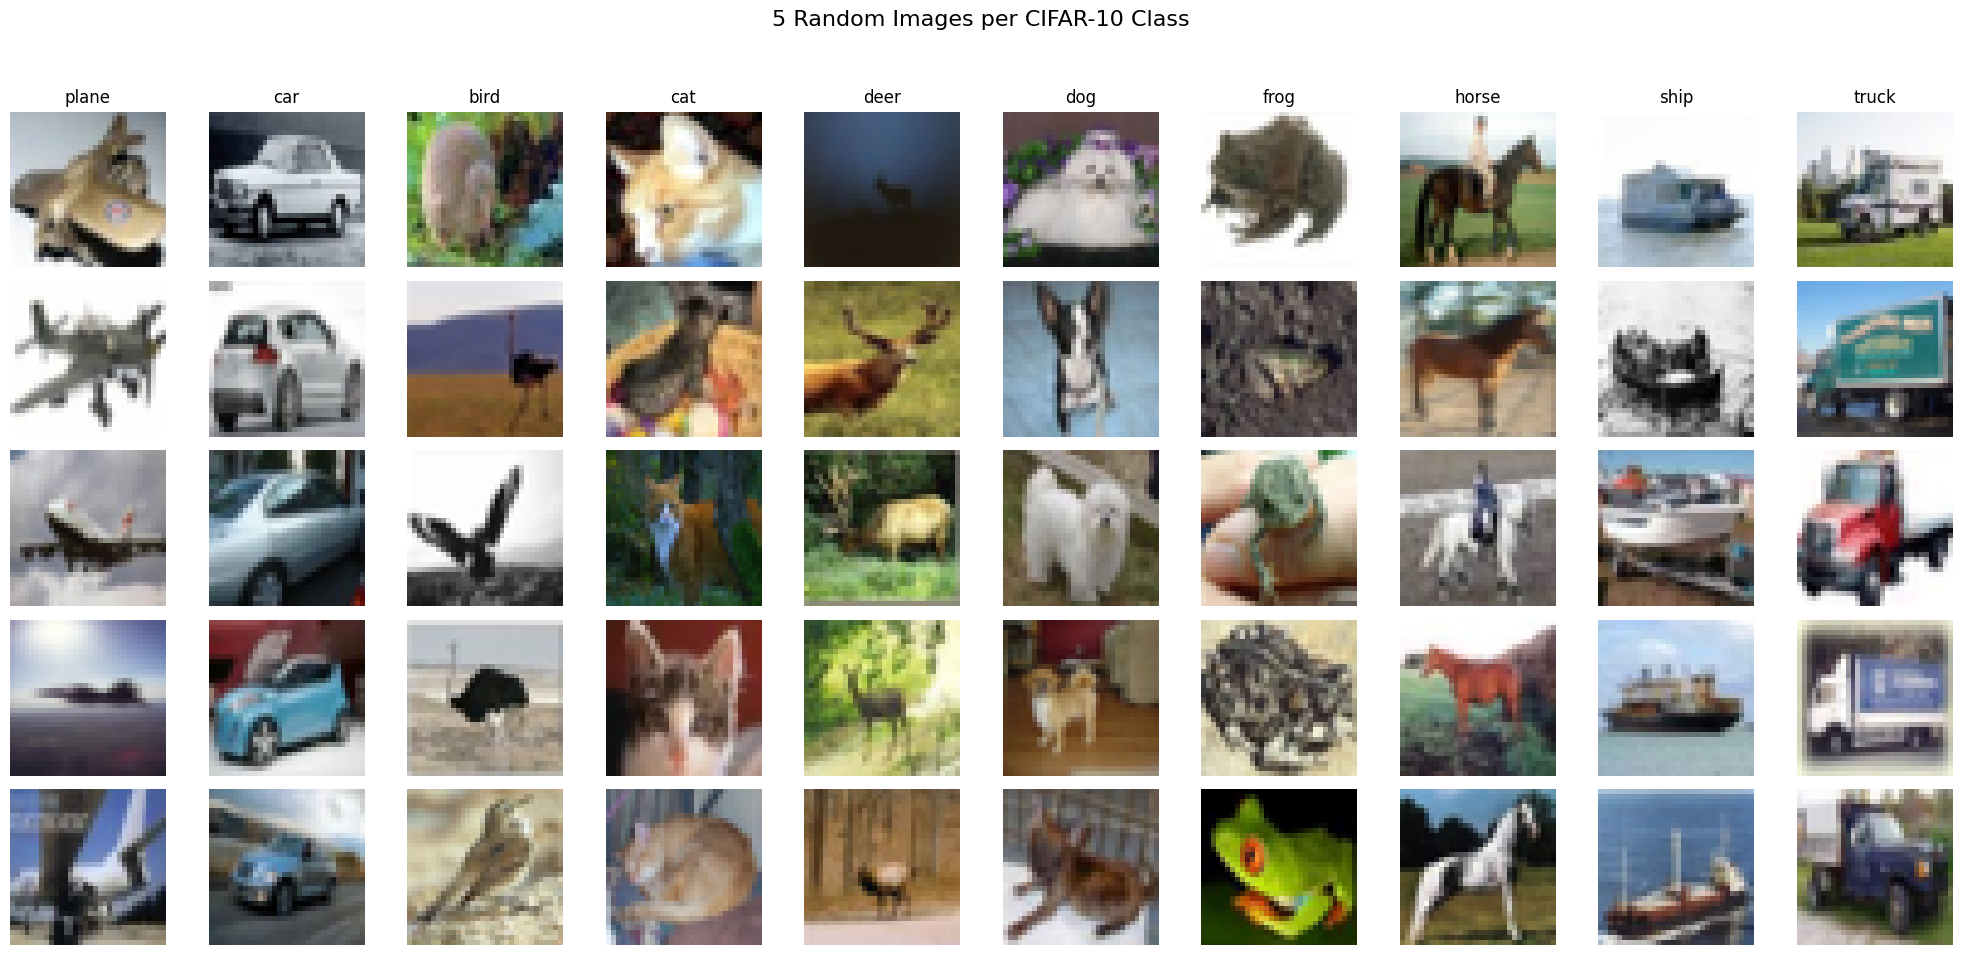

In [8]:
images_class = {}
for cls in classes:
    images_class[cls] = []

finished_collecting_images = False

for batch_idx, (images, labels) in enumerate(trainloader):
    if finished_collecting_images:
        break
    for i in range(images.size(0)):
        all_classes_full = all(len(img_list) == 5 for img_list in images_class.values())
        if all_classes_full:
            print("Collected 5 images for all classes. Stopping iteration.")
            finished_collecting_images = True
            break
        image = images[i]
        label = labels[i]
        class_name = classes[label]
        if len(images_class[class_name]) < 5:
          images_class[class_name].append(image.clone())


fig, axes = plt.subplots(5, len(classes), figsize=(20, 10))
fig.suptitle('5 Random Images per CIFAR-10 Class', fontsize=16)

for col, class_name in enumerate(classes):
    axes[0, col].set_title(class_name)
    current_class_images = images_class[class_name]
    for row in range(5):
        image = current_class_images[row]
        unnormalized_image = norminv(image)
        img_array = unnormalized_image.permute(1, 2, 0).numpy()
        img_array = np.clip(img_array, 0, 1)
        axes[row, col].imshow(img_array)
        axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Fully Connected Neural Netwrok

To ensure a fair comparison with convolutional neural networks (CNNs), both models should have approximately the same number of trainable parameters. Specifically, the fully connected model should contain **33,500,000 ± 500,000** trainable parameters.

## Model Construction:

- FullyConnectedNetwork : This class is a child of nn.module class, with our desired tailored needs.

- nn.Module: creating new modules by combining and extending the functionality provided by existing PyTorch modules. Includes some key features that are important for building neural networks, such as the ability to keep track of learnable parameters and the ability to perform automatic differentiation.

- super(FullyConnectedNetwork, self).__init__(): invokes the __init__ method to it's parent class, in other words calling nn.module's constructor.

- nn.Flatten: change tensor shape, with n being batch size:
  
  Input shape: (N, 3, 32, 32) --> output shape: (N, 3 * 32 * 32)

- nn.Linear: applies a linear transformation on the input using its stored weights and biases. y = Wx + b

- nn.ReLU: Non-linear activations will create complex mappings between the model's inputs and outputs.

- nn.Dropout: During training, in each forward pass, randomly zeroes some of the elements of the input tensor with probability p. Great for avoiding overfitting because the model learns Regularization, meaning no single neuron will carry the entire burden of representing a feature. Introduces more robustness.

- Logits: Is the raw output of the network, before any softmax or probability normalization


In [9]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10,
                 hidden_size=4096, drop_probability=0.5):
        super(FullyConnectedNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.hidden_linear_relu_stack = nn.Sequential(
            nn.Linear(input_shape[0] * input_shape[1] * input_shape[2], hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_probability),

            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_probability)
        )

        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden_linear_relu_stack(x)
        logits = self.linear(x)
        return logits


## Trainable params

Based on the defined architecture above, manually calculated the total number of trainable parameters:

for hidden_size  = 4096:

Hidden layer 1:

- Input features: 3 * 32 * 32 = 3072

- Output features: 4096

- Number of params: 4096 * 3072 (weights) + 4096 (biases) =  12,587,008 params

Hidden layer 2:

- Input features: 4096

- Output features: 4096

- Number of params: 4096 * 4096 (weights) + 4096 (biases) =  16,781,312 params

Final layer:

- Input features: 4096

- Output features: 10

- Number of params: 4096 * 10 (weights) + 10 (biases) =  40,970 params

Total params: 29,409,290


Once you have completed your hand calculation, you can verify your result by running the following cell:

In [11]:
from torchsummary import summary
summary(FullyConnectedNetwork(hidden_size=4096, drop_probability=0.5), input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 4096]      12,587,008
              ReLU-3                 [-1, 4096]               0
           Dropout-4                 [-1, 4096]               0
            Linear-5                 [-1, 4096]      16,781,312
              ReLU-6                 [-1, 4096]               0
           Dropout-7                 [-1, 4096]               0
            Linear-8                   [-1, 10]          40,970
Total params: 29,409,290
Trainable params: 29,409,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 112.19
Estimated Total Size (MB): 112.41
----------------------------------------------------------------


## Train

### Model Instantiation

Create an instance of your model and move it to your selected device (CPU or GPU). Refer to the PyTorch-tutorial notebook for guidance on how to perform this operation.

In [13]:
model = FullyConnectedNetwork().to('cpu')
print(model)

FullyConnectedNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden_linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (linear): Linear(in_features=4096, out_features=10, bias=True)
)


### Criterion & Optimizer


#### Criterion:
 To train a neural network, we require a **loss function** (referred to as the *criterion*) to quantify the difference between the model's predictions and the true labels. This loss is then used to compute the gradients of the model parameters.

- NLLLoss: Negative log likelihood loss.

In addition, an **optimization algorithm** is needed to update the model's parameters using the calculated gradients, in order to minimize the loss over time.

You are encouraged to read about the following PyTorch components:

* [`nn.CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
* [`torch.optim.Adam`](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [ ]:
criterion = None # YOUR CODE HERE
optimizer = None # YOUR CODE HERE

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    """
    Trains the neural network for a single epoch.

    Args:
        net (torch.nn.Module): The neural network model to be trained.
        criterion (torch.nn.Module): The loss function used to compute the training loss.
        optimizer (torch.optim.Optimizer): The optimization algorithm used to update model parameters.
        dataloader (torch.utils.data.DataLoader): DataLoader providing the training data in batches.

    Returns:
        tuple:
            - avg_loss (float): The average loss across all batches in the epoch.
            - accuracy (float): The classification accuracy (in percentage) over the entire dataset for the epoch.

    Notes:
        - The `criterion` computes the loss between the model's predictions and the true labels.
        - The `optimizer` updates the model's parameters based on the computed gradients to minimize the loss.
    """

    # YOUR CODE HERE

    avg_loss, accuracy = None, None
    return avg_loss, accuracy

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    """
    Evaluates the neural network on a validation or test dataset for one epoch.
    """
    net.eval()

    # YOUR CODE HERE

    avg_loss, accuracy = None, None
    return avg_loss, accuracy

As previously mentioned, ensuring a fair comparison between models requires consistency in certain aspects of the training setup. One key factor is the number of **trainable parameters**, and another is the number of times the model processes the entire dataset—referred to as an **epoch**.

To maintain consistency in training duration across models, **do not modify** the `epochs` variable defined below.


In [ ]:
epochs = 60 # Do not modify

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}


for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

### Save Model

Save the trained model for use in subsequent sections to avoid retraining it later.


In [ ]:
torch.save(model.state_dict(), "fully-connected.pth")

In [ ]:
# To load the previously saved model, simply uncomment the code below.
# model.load_state_dict(torch.load('fully-connected.pth'))

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

In [ ]:
# YOUR CODE HERE

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `60%`

In [ ]:
# YOUR CODE HERE

# Convolutional Neural Network

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

 You are encouraged to learn about the following core components commonly used in convolutional neural networks:

* [`nn.Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [`nn.MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

**Reminder**: The model you define should contain 33,500,000 ± 500,000 trainable parameters.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        # YOUR CODE HERE

        self.linear = nn.Linear # YOUR CODE HERE

    def forward(self, x):
        # YOUR CODE HERE


## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

`WRITE YOUR ANSWER HERE`

Once you have completed your hand calculation, you can verify your result by running the following cell:

In [ ]:
from torchsummary import summary
summary(CNN().to(device), input_size=(3, 32, 32));

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
model = None
# YOUR CODE HERE

### Criterion & Optimizer

Define `criterion` and `optimizer`

In [ ]:
# YOUR CODE HERE

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
epochs = 60 # Do not modify
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [ ]:
torch.save(model.state_dict(), "cnn.pth")

In [ ]:
# To load the previously saved model, simply uncomment the code below.
# model.load_state_dict(torch.load('cnn.pth'))

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

In [ ]:
# YOUR CODE HERE

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [ ]:
# YOUR CODE HERE

## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

In [ ]:
# YOUR CODE HERE

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(45000, N)` saved in a variable (for later usage)

- **Hint:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
# YOUR CODE HERE

### K Nearest Neighbor in feature space

We already have calculated the feature spaces for trainset ($S$) in the previous section. Now we follow these steps to explore the featre space:

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

In [ ]:
feature_space = None
# YOUR CODE HERE

### TSNE

Let's follow these steps to explore feature space even more:

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now we have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now we have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)


In [ ]:
from sklearn.manifold import TSNE

indices = np.random.randint(0, len(feature_space), 2000)
feature_space = feature_space[indices]
tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(feature_space.reshape(feature_space.shape[0], -1).detach().cpu().numpy())

In [ ]:
# YOUR CODE HERE

### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [ ]:
image = trainset[3][0]

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [ ]:
intermediate_output = None
# YOUR CODE HERE

In [ ]:
intermediate_output.shape

In [ ]:
import matplotlib.pyplot as plt

def plot_intermediate_output(result, title=None):
    """
    Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

plot_intermediate_output(intermediate_output, title='Feature Maps')


**Note:** You are expected to analyze all results presented in this notebook and thoughtfully consider the underlying reasons behind them. Be prepared to discuss your insights during the **in-person review session**.
A written report is not required.
